# Lab 9

In [1]:
# Units of variables given in the dataset:
#    elevation: meters above sea level
#    g: mm water equivalent per meter (db/dz)
#    continentality: degrees Celsius
#    cloud cover: percentage
#    summer temperature: degrees Celsius
#    precipitation: mm per year
#    average winter precipitation: mm per month 

# NOTE: climate variables are given from climatological gridded data (CRU) provided for the whole globe on ca 50x50 km grid
#
# Variables:
#                       g: [1x136 double]  glacier mass balance gradient (as an average over the observed period)
#        median_elevation: [1x136 double]  Median glacier elevation (derived from glacier hypsometry: glacier area vs elevation)
#      summer_temperature: [1x136 double]  Summer near-surface air temperature over a grid cell (ca 50x50 km) covering the glacier (averaged over the observed period)
#           precipitation: [1x136 double]  Total annaul precipitation over a grid cell (ca 50x50 km) covering the glacier (averaged over the observed period)
#                     lat: [1x136 double]  Geographical latitude of the glacier (in degrees)
#           max_elevation: [1x136 double]  Maximum glacier elevation
#                 WGMS ID: [1x136 int64]   Given glacier ID (from World Glacier Monitoring Service)
#    winter_precipitation: [1x136 double]  Same as for precipation but derived only over winter months 
#                     lon: [1x136 double]  Geographical longitude of the glacier (in degrees)
#             cloud_cover: [1x136 double]  Annual cloud cover over a grid cell (ca 50x50 km) covering the glacier (averaged over the observed period)
#          continentality: [1x136 double]  Maximum monthly temperature minus minimum monthly temperature over a year (over a grid cell covering the glacier and averaged over the observed period). The larger the continentality index the climate is more continental (rather than maritime). 

In [2]:
#import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
from sklearn.neural_network import MLPRegressor
from sklearn.decomposition import PCA

In [3]:
#define RMSE as a function, since we'll use this in the NN model 
def rmse(target,prediction):
    return(np.sqrt(((target - prediction)**2).sum()/len(target)))

In [5]:
#load the data, standardize and check it out (here we also normalize g)
data = pd.read_csv('glaciers.csv')
#clean data -- g<0 is non physical than this data point should be removed
data = data[data["g"]>0].reset_index(drop=True) 
data_norm = (data - data.mean())/data.std()
data_norm.tail()

,g,median_elevation,summer_temperature,precipitation,lat,max_elevation,winter_precipitation,lon,cloud_cover,continentality
130,-0.461272,-1.333215,-0.323683,-0.825336,0.620558,0.037507,-0.742943,-2.015930,1.098482,1.088167
131,0.312033,-0.544203,0.256879,-1.413473,0.708081,-0.359351,-1.384616,-1.995214,0.730708,1.816508
132,1.799200,-1.105615,-0.177693,-0.476557,0.491482,-1.138369,-0.229353,-1.840402,1.343131,0.125538
133,-1.140466,-0.400056,-0.405542,-1.600750,0.973747,-0.182970,-1.378192,-1.973098,0.323705,2.055146
134,1.204881,-0.483510,0.075430,-0.157370,0.048117,-0.590852,0.765539,-1.654376,0.660831,-0.154737


In [6]:
#unpack normalized data
lat = data['lat']
lat = np.abs(lat) # take absolute value of lat since we are interested only in how far north or south is the glacier
lat = (lat - lat.mean())/lat.std()
lon = data_norm['lon']
hmax = data_norm['max_elevation']
hmed = data_norm['median_elevation']
g = data_norm['g']
Pannual = data_norm['precipitation']
Pwinter = data_norm['winter_precipitation']
CI = data_norm['continentality']
cloud = data_norm['cloud_cover']
Tsummer = data_norm['summer_temperature']

In [7]:
#target variable: y; predictor variable(s): x
y = g
y-=np.min(g)
y/=np.max(g) #now y ranges from 0 to 1
x = data_norm.drop('g',axis=1)
y

0      0.406930
1      0.056375
2      0.468215
3      0.185647
4      0.199623
         ...   
130    0.196364
131    0.333132
132    0.596155
133    0.076241
134    0.491043
Name: g, Length: 135, dtype: float64

In [8]:
#first do PCA, then use PCs as predictors
n_modes = np.min(np.shape(x))
pca = PCA(n_components = n_modes)
PCs = pca.fit_transform(x)
eigvecs = pca.components_
fracVar = pca.explained_variance_ratio_

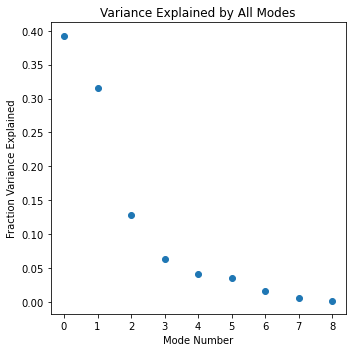

In [9]:
#plot fraction of variance explained by each mode

plt.figure(figsize=(5,5))

plt.subplot(1,1,1)
plt.scatter(range(len(fracVar)),fracVar)
plt.xlabel('Mode Number')
plt.ylabel('Fraction Variance Explained')
plt.title('Variance Explained by All Modes')

plt.tight_layout()

plt.show()

### MLP:

In [10]:
#take first 5 PCs in MLP NN model
#training: first 100 points
#testing: remaining points

ntrain = 100

x_train = PCs[:ntrain,:5] #train on 100 observations of first 5 PCs
y_train = y[:ntrain]

x_test = PCs[ntrain:,:5] #test on remaining observations
y_test = y[ntrain:]


In [12]:
#This chunk of code is relatively flexible and can be used to loop through a range of parameters
#We'll use this code several different times in the notebook
#Play around and see what kinds of models you can make

#First: MLP using 1 hidden layer with 10 neurons
#Second: MLP using 1 hidden layer with 1-10 neurons
#Third: something else!

##### Play around with these parameters
num_models = 10 #number of models to build for the ensemble
min_nhn = 1 #minimum number of hidden neurons to loop through (nhn = 'number hidden neurons')
max_nhn = 9 #maximum number of hidden neurons to loop through
max_hidden_layers = 1 #maximum number of hidden layers to loop through (nhl = 'number hidden layers')
batch_size = 32
solver = 'adam' #use stochastic gradient descent as an optimization method (weight updating algorithm)
activation = 'relu'
learning_rate_init = 0.01
#####

max_iter = 1500 #max number of epochs to run
early_stopping = True #True = stop early if validation error begins to rise
validation_fraction = 0.1 #fraction of training data to use as validation

y_out_all_nhn = []
y_out_ensemble = []
RMSE_ensemble = [] #RMSE for each model in the ensemble
RMSE_ensemble_cumsum = [] #RMSE of the cumulative saltation for each model
nhn_best = []
nhl_best = []

for model_num in range(num_models): #for each model in the ensemble
    
    print('Model Number: ' + str(model_num))
    
    RMSE = []
    y_out_all_nhn = []
    nhn = []
    nhl = []
    
    for num_hidden_layers in range(1,max_hidden_layers+1):
    
        print('\t # Hidden Layers = ' + str(num_hidden_layers))
    
        for num_hidden_neurons in range(min_nhn,max_nhn+1): #for each number of hidden neurons

            print('\t\t # hidden neurons = ' + str(num_hidden_neurons))
            
            hidden_layer_sizes = (num_hidden_neurons,num_hidden_layers)
            model = MLPRegressor(hidden_layer_sizes=hidden_layer_sizes, 
                                 verbose=False,
                                 max_iter=max_iter, 
                                 early_stopping = early_stopping,
                                 validation_fraction = validation_fraction,
                                 batch_size = batch_size,
                                 solver = solver,
                                 activation = activation,
                                 learning_rate_init = learning_rate_init)

            model.fit(x_train,y_train) #train the model

            y_out_this_nhn = model.predict(x_test) #model prediction for this number of hidden neurons (nhn)
            y_out_all_nhn.append(y_out_this_nhn) #store all models -- will select best one best on RMSE

            RMSE.append(rmse(y_test,y_out_this_nhn)) #RMSE between cumulative curves
            
            nhn.append(num_hidden_neurons)
            nhl.append(num_hidden_layers)
        
    indBest = RMSE.index(np.min(RMSE)) #index of model with lowest RMSE
    RMSE_ensemble.append(np.min(RMSE))
    nhn_best.append(nhn[indBest])
    nhl_best.append(nhl[indBest])
    #nhn_best.append(indBest+1) #the number of hidden neurons that achieved best model performance of this model iteration
    y_out_ensemble.append(y_out_all_nhn[indBest])
    
    print('\t BEST: ' + str(nhl_best[model_num]) + ' hidden layers, '+ str(nhn_best[model_num]) + ' hidden neurons')
    
y_out_ensemble_mean = np.mean(y_out_ensemble,axis=0)
RMSE_ensemble_mean = rmse(y_out_ensemble_mean,y_test)

Model Number: 0
	 # Hidden Layers = 1
		 # hidden neurons = 1
		 # hidden neurons = 2
		 # hidden neurons = 3
		 # hidden neurons = 4
		 # hidden neurons = 5
		 # hidden neurons = 6
		 # hidden neurons = 7
		 # hidden neurons = 8
		 # hidden neurons = 9
	 BEST: 1 hidden layers, 5 hidden neurons
Model Number: 1
	 # Hidden Layers = 1
		 # hidden neurons = 1
		 # hidden neurons = 2
		 # hidden neurons = 3
		 # hidden neurons = 4
		 # hidden neurons = 5
		 # hidden neurons = 6
		 # hidden neurons = 7
		 # hidden neurons = 8
		 # hidden neurons = 9
	 BEST: 1 hidden layers, 5 hidden neurons
Model Number: 2
	 # Hidden Layers = 1
		 # hidden neurons = 1
		 # hidden neurons = 2
		 # hidden neurons = 3
		 # hidden neurons = 4
		 # hidden neurons = 5
		 # hidden neurons = 6
		 # hidden neurons = 7
		 # hidden neurons = 8
		 # hidden neurons = 9
	 BEST: 1 hidden layers, 9 hidden neurons
Model Number: 3
	 # Hidden Layers = 1
		 # hidden neurons = 1
		 # hidden neurons = 2
		 # hidden neurons = 3
		

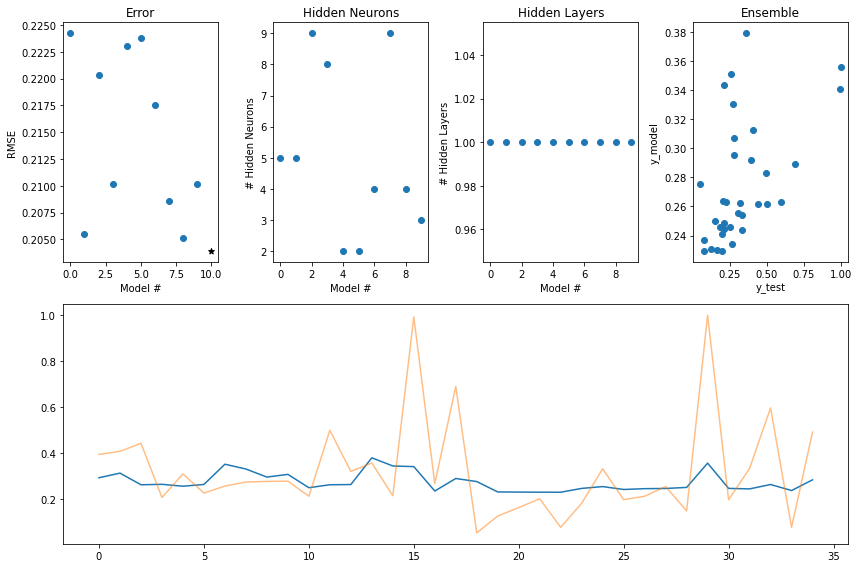

In [13]:
#visualize

plt.figure(figsize=(12,8))

plt.subplot(241)
plt.scatter(len(RMSE_ensemble),RMSE_ensemble_mean,c='k',marker='*')
plt.scatter(range(len(RMSE_ensemble)),RMSE_ensemble)
plt.xlabel('Model #')
plt.ylabel('RMSE')
plt.title('Error')

plt.subplot(242)
plt.scatter(range(len(nhn_best)),nhn_best)
plt.xlabel('Model #')
plt.ylabel('# Hidden Neurons')
plt.title('Hidden Neurons')

plt.subplot(243)
plt.scatter(range(len(nhl_best)),nhl_best)
plt.xlabel('Model #')
plt.ylabel('# Hidden Layers')
plt.title('Hidden Layers')

plt.subplot(244)
plt.scatter(y_test,y_out_ensemble_mean)
#plt.plot((np.min(y_test),np.max(y_test)),'k--')
plt.xlabel('y_test')
plt.ylabel('y_model')
plt.title('Ensemble')

plt.subplot(212)
plt.plot(y_out_ensemble_mean)
plt.plot(np.array(y_test),alpha = 0.5)

plt.tight_layout()

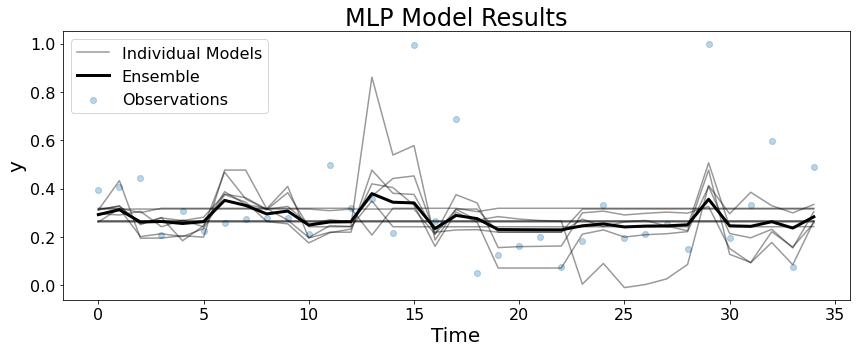

In [14]:
#visualize individual model runs

saveIt = 0

plt.figure(figsize = (12,5))

plt.scatter(range(len(y_test)),y_test,label='Observations',zorder = 0,alpha = 0.3)
plt.plot(range(len(y_test)),np.transpose(y_out_ensemble[0]),color = 'k',alpha = 0.4,label='Individual Models',zorder=1) #plot first ensemble member with a label
plt.plot(range(len(y_test)),np.transpose(y_out_ensemble[1:]),color = 'k',alpha = 0.4,zorder=1) #plot remaining ensemble members without labels for a nicer legend
plt.plot(range(len(y_test)),y_out_ensemble_mean,color = 'k',label = 'Ensemble',zorder=2, linewidth = 3)
plt.xlabel('Time', fontsize = 20)
plt.ylabel('y', fontsize = 20)
plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)
plt.title('MLP Model Results', fontsize = 24)
plt.legend(fontsize = 16, loc = 'best')

plt.tight_layout()

if saveIt:
    plt.savefig('tutorial10_fig12.png')

plt.show()

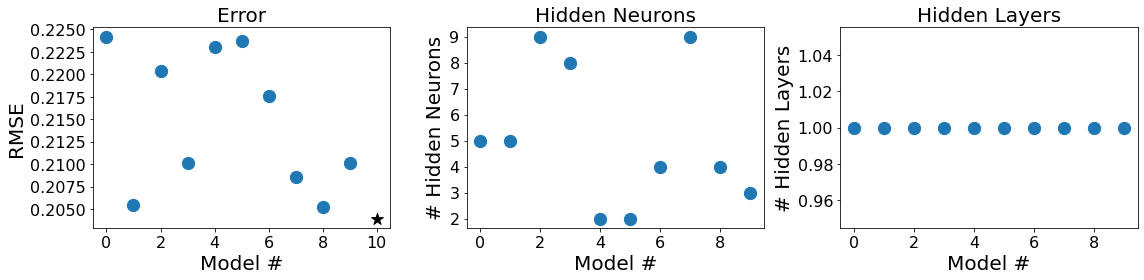

In [15]:
#visualize performance metrics/etc

saveIt = 0

plt.figure(figsize=(16,4))

plt.subplot(131)
plt.scatter(len(RMSE_ensemble),RMSE_ensemble_mean,c='k',marker='*', s = 150)
plt.scatter(range(len(RMSE_ensemble)),RMSE_ensemble, s = 150)
plt.xlabel('Model #', fontsize = 20)
plt.ylabel('RMSE', fontsize = 20)
plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)
#plt.ylim((np.min(RMSE_ensemble) - 0.005, np.max(RMSE_ensemble)+0.005))
plt.title('Error', fontsize = 20)

plt.subplot(132)
plt.scatter(range(len(nhn_best)),nhn_best, s = 150)
plt.xlabel('Model #', fontsize = 20)
plt.ylabel('# Hidden Neurons', fontsize = 20)
plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)
plt.title('Hidden Neurons', fontsize = 20)

plt.subplot(133)
plt.scatter(range(len(nhl_best)),nhl_best, s = 150)
plt.xlabel('Model #', fontsize = 20)
plt.ylabel('# Hidden Layers', fontsize = 20)
plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)
plt.title('Hidden Layers', fontsize = 20)

plt.tight_layout()

if saveIt:
    plt.savefig('tutorial10_fig10.png')
    
plt.show()